<a href="https://colab.research.google.com/github/w-dan/MATM/blob/main/MATM-code/data-analysis/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and libraries

Installation of necessary libraries, importing my mongodb connection string and setting English stopwords.

In [104]:
import importlib.util

def install_if_not_exists(package_name, module_name=None):
  """
    Installs the specified Python package if it is not already installed.
    Optionally installs a specific module for the package.

    Args:
    package_name (str): The name of the Python package to install.
    module_name (str): Optional. The name of a module to install after installing the package.

    Returns:
    None
  """
  spec = importlib.util.find_spec(package_name)
  if spec is None:
      print(f"[+] Installing {package_name}...")
      !pip install {package_name} --quiet
      if module_name:
          print(f"[+] Installing {module_name}...")
          !python3 -m spacy download {module_name} --quiet
  else:
      print(f"{package_name} is already installed.")


install_if_not_exists("pymongo")
install_if_not_exists("seaborn")
install_if_not_exists("typing-extensions")

pymongo is already installed.
seaborn is already installed.
[+] Installing typing-extensions...


In [ ]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import re, os, sys

from nltk import ngrams, word_tokenize, FreqDist, sent_tokenize
from typing import Tuple, List, Dict, Union
from nltk.probability import FreqDist

from tqdm.notebook import tqdm_notebook
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from bert_utils import *
from eda_utils import *
import nltk

In [ ]:
from dotenv import load_dotenv
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
DATABASE_NAME = "APTs"

# Database connection

Connecting to the database and creating databases and collections (if necessary).

* **Why not use a static dataset?**
Reports are stored in a database because I expect them to grow in number in the near future, so obtaining them via queries would be way more versatile in terms of scalability.

In [105]:
client = MongoClient(CONNECTION_STRING)

raw_reports_collection_name = "raw_reports"
preprocessed_collection_name = "non_unicode_reports"


if 'APTs' in client.list_database_names():
    db = client['APTs']

    if "clean_reports" not in db.list_collection_names():
        collection = db.create_collection("clean_reports")
        print("[+] Collection 'clean_reports' created successfully.")

    if preprocessed_collection_name not in db.list_collection_names():
        collection = db.create_collection(preprocessed_collection_name)
        print(f"[+] Collection {preprocessed_collection_name} created successfully.")

    clean_collection = db['clean_reports']
    raw_reports_collection = db[raw_reports_collection_name]
    preprocessed_collection = db[preprocessed_collection_name]
    test_collection = db['test_collection']

    print(f"[+] Successfully connected to database {db.name}, with collection 'clean_reports'")
else:
    print(f"[-] Error connecting to database at port {MONGODB_PORT}")

[+] Successfully connected to database APTs, with collection 'clean_reports'


# Preprocessing


This section involves the following steps:

1. Splitting the text in tokens
    * A rule-based tokenizer was defined to preserve URLs and IP addresses as individual tokens.

2. Preprocessing tokens to make information extraction easier
    * Transforming them into lowercase
    * Lemmatizing and steming




Splitting the text first and cleaning tokens after was observed to yield better results. Defining a rule-based tokenizer with regex proved useful, since symbols such as dashes and fullstops were filtered from the beginning.

# Exploratory Data Analysis

For the Exploratory Data Analysis, the training data will be stored within Pandas dataframes (as they will not be modified in this step) to add derivative measures. Both raw and preprocessed reports will be analyzed to evaluate how preprocessing impacts our data.

## Raw Reports Analysis

In [ ]:
raw_data_df = fetch_corpora(DATABASE_NAME, raw_reports_collection_name, CONNECTION_STRING)

[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Shape: (4495, 1)


In [ ]:
raw_df_with_stats = analyze_corpus_statistics(raw_data_df)
raw_df_with_stats.head()

,corpus,num_clauses,text_length,average_clause_length,average_corpus_length,corpus_std,clause_std,longest_clause,shortest_clause
0,Decoding network data from a Gh0st RAT variant...,35,1063,30.371429,1063.0,0.0,23.238005,135,5
1,1 / 1 5www .prevailion.com /what-wicked-webs-...,198,5416,27.353535,5416.0,0.0,47.479674,651,2
2,1 / 7www .mandiant.com /resources/blog/lights...,49,1805,36.836735,1805.0,0.0,53.889284,392,2
3,2015/11/24 Russian financial cybercrime: how i...,257,7525,29.280156,7525.0,0.0,18.443713,170,2
4,"9/28/21, 4:23 PM FoggyW eb: T argeted NOBELIUM...",165,6051,36.672727,6051.0,0.0,26.960164,216,7


Analyzing corpus and clause length:

In [ ]:
global_stats = calculate_global_statistics(raw_data_df)

print("Global Statistics:")
print(f"Average Corpus Length: {global_stats['average_corpus_length']}")
print(f"Corpus Length Std Dev: {global_stats['std_corpus_length']}")
print(f"Min Corpus Length: {global_stats['min_corpus_length']}")
print(f"Max Corpus Length: {global_stats['max_corpus_length']}")
print(f"Average Clause Length: {global_stats['average_clause_length']}")
print(f"Clause Length Std Dev: {global_stats['std_clause_length']}")
print(f"Min Clause Length: {global_stats['min_clause_length']}")
print(f"Max Clause Length: {global_stats['max_clause_length']}")

Global Statistics:
Average Corpus Length: 5272.149721913237
Corpus Length Std Dev: 8105.09530301722
Min Corpus Length: 0.0
Max Corpus Length: 156864.0
Average Clause Length: 47.07737918268813
Clause Length Std Dev: 157.8069531958165
Min Clause Length: 0.0
Max Clause Length: 4842.0


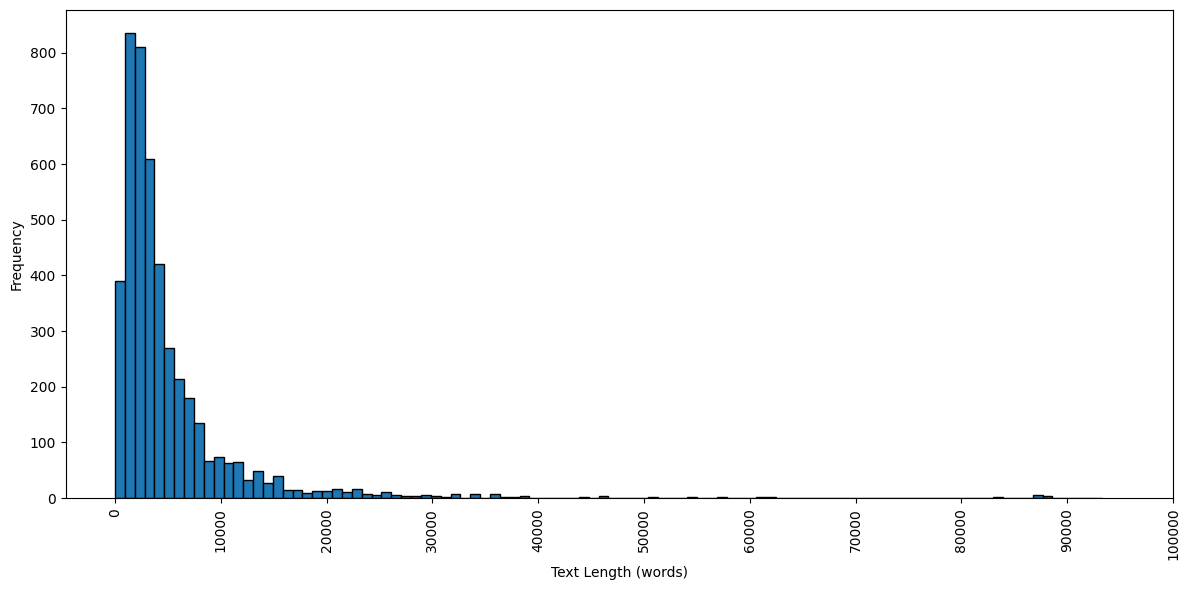

In [ ]:
filtered_df = raw_df_with_stats[raw_df_with_stats['text_length'] <= 100000]

plt.figure(figsize=(12, 6))
plt.hist(filtered_df['text_length'].values, bins=100, edgecolor='k')

plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')

max_text_length = filtered_df['text_length'].max()
plt.xticks(np.arange(start=0, stop=max_text_length + 10000, step=10000))  # Adjust 'step' as needed

plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

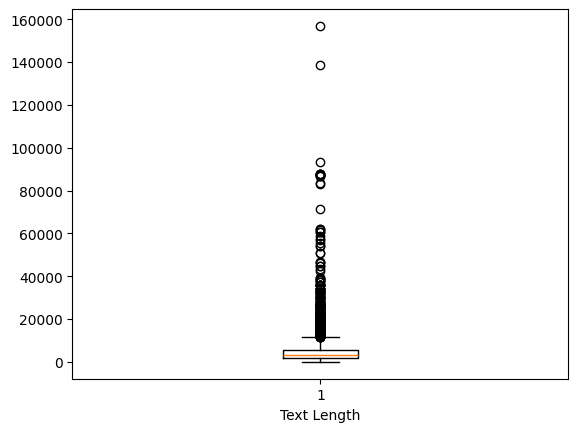

In [ ]:
plt.boxplot(raw_df_with_stats['text_length'].values)
plt.xlabel('Text Length')
# plt.title('Text Length Distribution')
plt.show()

N-gram analysis would not be representative in a dataset with no preprocessing applied, since puncutation symbols would be present. Also, capitalized instances of the same words would interfere with n-gram analysis.

## Preprocessed Reports Analysis

In [ ]:
clean_data_df = fetch_corpora(DATABASE_NAME, "clean_reports", CONNECTION_STRING)

[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Shape: (4495, 1)


In [ ]:
clean_df_with_stats = analyze_corpus_statistics(clean_data_df)
clean_df_with_stats.head()

,corpus,num_clauses,text_length,average_clause_length,average_corpus_length,corpus_std,clause_std,longest_clause,shortest_clause
0,decoding network data gh0st rat variant nccgro...,1,526,526.000000,526.0,0.0,0.000000,526,526
1,5www .prevailion.com /what-wicked-webs-we-unwe...,7,3054,436.285714,3054.0,0.0,440.229393,1295,9
2,7www .mandiant.com /resources/blog/lightshift-...,1,977,977.000000,977.0,0.0,0.000000,977,977
3,2015/11/24 russian financial cybercrime works ...,8,3873,484.125000,3873.0,0.0,227.375481,818,108
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,1,3437,3437.000000,3437.0,0.0,0.000000,3437,3437


Corpus and clause length analysis:

In [ ]:
global_stats = calculate_global_statistics(clean_data_df)

print("Global Statistics:")
print(f"Average Corpus Length: {global_stats['average_corpus_length']}")
print(f"Corpus Length Std Dev: {global_stats['std_corpus_length']}")
print(f"Min Corpus Length: {global_stats['min_corpus_length']}")
print(f"Max Corpus Length: {global_stats['max_corpus_length']}")
print(f"Average Clause Length: {global_stats['average_clause_length']}")
print(f"Clause Length Std Dev: {global_stats['std_clause_length']}")
print(f"Min Clause Length: {global_stats['min_clause_length']}")
print(f"Max Clause Length: {global_stats['max_clause_length']}")

Global Statistics:
Average Corpus Length: 2881.187319243604
Corpus Length Std Dev: 4599.67733708715
Min Corpus Length: 0.0
Max Corpus Length: 90908.0
Average Clause Length: 1448.5830839841963
Clause Length Std Dev: 1482.6953469311138
Min Clause Length: 0.0
Max Clause Length: 20729.0


In [ ]:
min_value = raw_df_with_stats[raw_df_with_stats['text_length'] > 49]['text_length'].min()
print(f"Min text length: {min_value}")

Min text length: 96


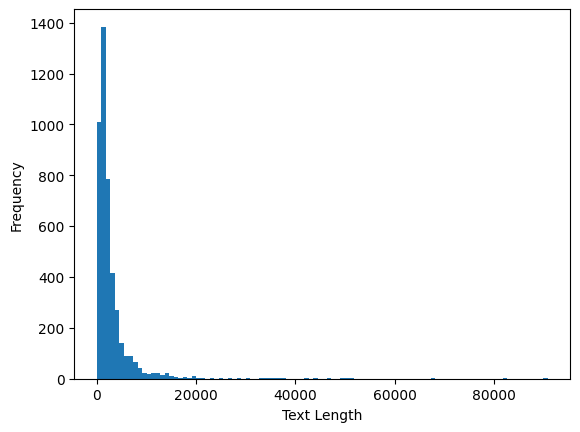

In [ ]:
plt.hist(clean_df_with_stats['text_length'].values, bins=100)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
# plt.title('Text Length Distribution')
plt.show()

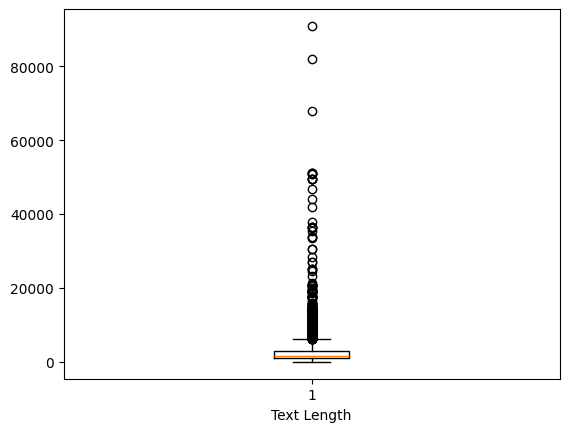

In [ ]:
plt.boxplot(clean_df_with_stats['text_length'].values)
plt.xlabel('Text Length')
# plt.title('Text Length Distribution')
plt.show()

N-gram analysis:

In [ ]:
for n in range(1, 5):
  print_top_ngrams(clean_df_with_stats, n)

[📋] Top 1-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  `` with frequency: 120212
	 ╰─  malware with frequency: 72087
	 ╰─  used with frequency: 65159
	 ╰─  file with frequency: 62162
	 ╰─  threat with frequency: 47408
	 ╰─  data with frequency: 45353
	 ╰─  information with frequency: 43744
	 ╰─  group with frequency: 39801
	 ╰─  also with frequency: 39504
	 ╰─  https with frequency: 39344
[📋] Top 2-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  `` `` with frequency: 18641
	 ╰─  -- -- with frequency: 15223
	 ╰─  00 00 with frequency: 13332
	 ╰─  threat actor with frequency: 11366
	 ╰─  threat actors with frequency: 8501
	 ╰─  ip address with frequency: 7275
	 ╰─  command control with frequency: 6067
	 ╰─  c2 server with frequency: 5694
	 ╰─  https //www with frequency: 4531
	 ╰─  threat intelligence with frequency: 4451
[📋] Top 3-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  -- -- -- with frequency: 13778
	 ╰─  00 00 00 with frequency: 9510
	 ╰─  `` `` `` with frequency: 3344
	 ╰─  asian apt groups with frequency: 2237
	 ╰─  threat actor encyclopedia with frequency: 1805
	 ╰─  contact intelreports kaspersky.com with frequency: 1598
	 ╰─  please contact intelreports with frequency: 1597
	 ╰─  groups tactics techniques with frequency: 1476
	 ╰─  apt groups tactics with frequency: 1475
	 ╰─  modern asian apt with frequency: 1474
[📋] Top 4-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  -- -- -- -- with frequency: 12931
	 ╰─  00 00 00 00 with frequency: 6881
	 ╰─  `` `` `` `` with frequency: 1737
	 ╰─  asian apt groups tactics with frequency: 1475
	 ╰─  apt groups tactics techniques with frequency: 1475
	 ╰─  modern asian apt groups with frequency: 1474
	 ╰─  contents modern asian apt with frequency: 1464
	 ╰─  please contact intelreports kaspersky.com with frequency: 1370
	 ╰─  threat group cards threat with frequency: 989
	 ╰─  group cards threat actor with frequency: 989


# Non-unicode for clause analysis:

In [ ]:
no_unicode_clean_df = fetch_and_preprocess_data(DATABASE_NAME, "non_unicode_reports", CONNECTION_STRING,
                                                preprocess=True, include_tactics=True, field_to_get="tactics")

[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Shape: (4495, 2)


In [ ]:
no_unicode_clean_df

,corpus,tactics
0,proofpoint com triple threat north korea align...,
1,energetic bear crouch yeti global research ana...,
2,_ clearsky cyber security clearskysec com page...,
3,5 16 2019 winnti w indow gate chronicle blog m...,
4,cisak 2013 c1 8 dark seoul cyber tack could w ...,
...,...,...
4490,secret comfoo mastersauthor joe stewart jackso...,
4491,threat intelligence report cyberattack ukraini...,
4492,1 visa security alert august 2016 r c l e I c ...,
4493,1 3graphiron new russian information steal mal...,


In [ ]:
no_unicode_clean_df = analyze_corpus_statistics(no_unicode_clean_df)
non_uc_stats = calculate_global_statistics(no_unicode_clean_df)

In [ ]:
print("Global Statistics:")
print(f"Average Corpus Length: {non_uc_stats['average_corpus_length']}")
print(f"Corpus Length Std Dev: {non_uc_stats['std_corpus_length']}")
print(f"Min Corpus Length: {non_uc_stats['min_corpus_length']}")
print(f"Max Corpus Length: {non_uc_stats['max_corpus_length']}")
print(f"Average Clause Length: {non_uc_stats['average_clause_length']}")
print(f"Clause Length Std Dev: {non_uc_stats['std_clause_length']}")
print(f"Min Clause Length: {non_uc_stats['min_clause_length']}")
print(f"Max Clause Length: {non_uc_stats['max_clause_length']}")

Global Statistics:
Average Corpus Length: 3356.7201334816464
Corpus Length Std Dev: 5119.830224378901
Min Corpus Length: 0.0
Max Corpus Length: 97145.0
Average Clause Length: 2953.259690456461
Clause Length Std Dev: 4847.543572573366
Min Clause Length: 0.0
Max Clause Length: 97145.0


# Vendor-specific dataset

In [106]:
blackberry_df = fetch_and_preprocess_data(DATABASE_NAME, "blackberry_vendor", CONNECTION_STRING,
                                          preprocess=True, include_tactics=True, field_to_get="techniques")


[+] Shape: (300, 2)


[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
blackberry_df = blackberry_df[blackberry_df['tactics'].str.len() != 0]


In [108]:
blackberry_df

,corpus,tactics
0,As part of our continuous hunting efforts acro...,"[Resource Development, Initial Access, Executi..."
1,"In late 2023, BlackBerry analysts identified a...","[Resource Development, Initial Access, Executi..."
2,This report details the resurgence of the Ligh...,[Execution]
4,A financially motivated threat actor is target...,"[Initial Access, Execution, Defense Evasion, C..."
5,BlackBerry has uncovered a previously unknown ...,"[Initial Access, Execution, Persistence, Defen..."
...,...,...
273,The Cylance Threat Guidance team continuously ...,[Execution]
281,The SPEAR™ Team has once again jumped back int...,"[Persistence, Command and Control]"
283,Today’s malware often employs techniques to at...,[Persistence]
285,"Like all great malware stories, it starts with...",[Execution]


In [ ]:
blackberry_stats_df = analyze_corpus_statistics(blackberry_df)
blackberry_stats = calculate_global_statistics(blackberry_df)


print("Global Statistics:")
print(f"Average Corpus Length: {blackberry_stats['average_corpus_length']}")
print(f"Corpus Length Std Dev: {blackberry_stats['std_corpus_length']}")
print(f"Min Corpus Length: {blackberry_stats['min_corpus_length']}")
print(f"Max Corpus Length: {blackberry_stats['max_corpus_length']}")
print(f"Average Clause Length: {blackberry_stats['average_clause_length']}")
print(f"Clause Length Std Dev: {blackberry_stats['std_clause_length']}")
print(f"Min Clause Length: {blackberry_stats['min_clause_length']}")
print(f"Max Clause Length: {blackberry_stats['max_clause_length']}")

Global Statistics:
Average Corpus Length: 2724.0714285714284
Corpus Length Std Dev: 1670.2279313465283
Min Corpus Length: 427.0
Max Corpus Length: 8111.0
Average Clause Length: 28.383710301268643
Clause Length Std Dev: 7.332961409172808
Min Clause Length: 2.347935368043088
Max Clause Length: 46.336363636363636


/home/dani/eda_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[key] = value
/home/dani/eda_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[key] = value
/home/dani/eda_utils.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
for n in range(1, 5):
  print_top_ngrams(blackberry_df, n)

[📋] Top 1-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  . with frequency: 7176
	 ╰─  the with frequency: 7110
	 ╰─  , with frequency: 6872
	 ╰─  to with frequency: 3637
	 ╰─  and with frequency: 3185
	 ╰─  of with frequency: 3156
	 ╰─  ? with frequency: 2925
	 ╰─  a with frequency: 2784
	 ╰─  : with frequency: 2707
	 ╰─  [ with frequency: 2324
[📋] Top 2-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  ? ? with frequency: 2370
	 ╰─  [ . with frequency: 1769
	 ╰─  . ] with frequency: 1769
	 ╰─  . The with frequency: 960
	 ╰─  of the with frequency: 804
	 ╰─  00 00 with frequency: 587
	 ╰─  , and with frequency: 575
	 ╰─  ’ s with frequency: 558
	 ╰─  , the with frequency: 553
	 ╰─  in the with frequency: 549
[📋] Top 3-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  ? ? ? with frequency: 1921
	 ╰─  [ . ] with frequency: 1768
	 ╰─  00 00 00 with frequency: 484
	 ╰─  '' , `` with frequency: 255
	 ╰─  . ] com with frequency: 228
	 ╰─  [ : ] with frequency: 136
	 ╰─  48 ? ? with frequency: 119
	 ╰─  victim ’ s with frequency: 117
	 ╰─  ? 48 ? with frequency: 106
	 ╰─  the threat actor with frequency: 105
[📋] Top 4-grams:


Calculating N-gram frequencies:   0%|          | 0/10 [00:00<?, ?it/s]

	 ╰─  ? ? ? ? with frequency: 1559
	 ╰─  00 00 00 00 with frequency: 398
	 ╰─  [ . ] com with frequency: 228
	 ╰─  48 ? ? ? with frequency: 119
	 ╰─  ? 48 ? ? with frequency: 106
	 ╰─  ? ? 48 ? with frequency: 103
	 ╰─  ? ? ? 48 with frequency: 97
	 ╰─  [ . ] rtf with frequency: 95
	 ╰─  . ] rtf URL with frequency: 91
	 ╰─  the victim ’ s with frequency: 80


In [109]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()

    # rule-based tokenization
    rule_based_tokenizer_pattern = r'\b(?:https?://\S+|www\.\S+|\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b|\w+'
    tokens = re.findall(rule_based_tokenizer_pattern, text)

    # stopwords and symbols other than ':', '.', and '/'
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words and re.match(r'^[a-zA-Z0-9:/\.]+$', token)]

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

[nltk_data] Downloading package wordnet to /home/dani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
blackberry_df['preprocessed_corpus'] = blackberry_df['corpus'].apply(preprocess_text)
blackberry_df

,corpus,tactics,preprocessed_corpus
0,As part of our continuous hunting efforts acro...,"[Resource Development, Initial Access, Executi...",part continuous hunting effort across asia pac...
1,"In late 2023, BlackBerry analysts identified a...","[Resource Development, Initial Access, Executi...",late 2023 blackberry analyst identified spear ...
2,This report details the resurgence of the Ligh...,[Execution],report detail resurgence lightspy mobile espio...
4,A financially motivated threat actor is target...,"[Initial Access, Execution, Defense Evasion, C...",financially motivated threat actor targeting m...
5,BlackBerry has uncovered a previously unknown ...,"[Initial Access, Execution, Persistence, Defen...",blackberry uncovered previously unknown threat...
...,...,...,...
273,The Cylance Threat Guidance team continuously ...,[Execution],cylance threat guidance team continuously look...
281,The SPEAR™ Team has once again jumped back int...,"[Persistence, Command and Control]",spear team jumped back tracking monitoring thr...
283,Today’s malware often employs techniques to at...,[Persistence],today malware often employ technique attempt e...
285,"Like all great malware stories, it starts with...",[Execution],like great malware story start email inside em...


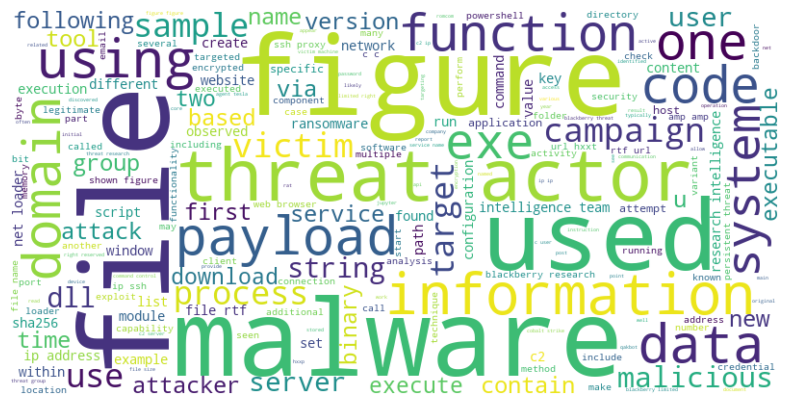

In [111]:
from wordcloud import WordCloud

text = ' '.join(blackberry_df['preprocessed_corpus'].values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # hiding the axes
plt.show()

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(blackberry_df['preprocessed_corpus'])

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(blackberry_df['tactics'])

words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tactics_df = pd.DataFrame(Y, columns=mlb.classes_)

combined_df = pd.concat([words_df, tactics_df], axis=1)

correlation_matrix = combined_df.corr()

word_tactic_correlations = correlation_matrix.loc[vectorizer.get_feature_names_out(), mlb.classes_]

print(word_tactic_correlations)

                                  Collection  Command and Control  \
00                                 -0.045111            -0.105648   
000                                 0.125034            -0.191892   
00000000                           -0.054780             0.150926   
000000006bbc3040                   -0.043244            -0.078811   
000000006bbc3050                   -0.043244            -0.078811   
...                                      ...                  ...   
zwwritevirtualmemory               -0.043244             0.183892   
zxlbw                              -0.043244            -0.078811   
zyxgfedcba                          0.335140             0.183892   
zz                                 -0.043244            -0.078811   
zzlbgoam08z5ut2uz5krbt9vghwgtone   -0.043244            -0.078811   

                                  Credential Access  Defense Evasion  \
00                                        -0.007819         0.163464   
000                        

In [113]:
def get_top_correlations_per_label(correlation_matrix, top_n=10):
    top_correlations_dict = {}
    for label in correlation_matrix.columns:
        top_correlations = correlation_matrix[label].sort_values(ascending=False).head(top_n)
        top_correlations_dict[label] = top_correlations
    return top_correlations_dict

# Get top correlations for each label
top_correlations_per_label = get_top_correlations_per_label(word_tactic_correlations)

# Print the top correlations for each label
for label, correlations in top_correlations_per_label.items():
    print(f"Top correlations for '{label}':")
    print(correlations)
    print("\n")

# Alternatively, you can convert the top correlations into a more structured format, like a DataFrame, for better readability.
top_correlations_df = pd.DataFrame(top_correlations_per_label)
print(top_correlations_df)

Top correlations for 'Collection':
institute       0.589080
aligned         0.554013
persist         0.526238
xlsx            0.523318
embed           0.491900
consistently    0.491900
08              0.491574
t1140           0.480568
t1560           0.477432
specializing    0.477432
Name: Collection, dtype: float64


Top correlations for 'Command and Control':
neutralizes    0.450721
resilience     0.418060
putting        0.402593
stopping       0.402593
streamline     0.400472
belonging      0.400381
suite          0.368219
term           0.364758
ssl            0.360344
prevention     0.359569
Name: Command and Control, dtype: float64


Top correlations for 'Credential Access':
latin       0.808149
mexico      0.805405
t1219       0.694827
enough      0.679850
america     0.676468
mandiant    0.651741
couple      0.651741
007         0.637838
usd         0.608773
t1105       0.595235
Name: Credential Access, dtype: float64


Top correlations for 'Defense Evasion':
t1059        0.738

In [114]:
def get_top_negative_correlations_per_label(correlation_matrix, top_n=10):
    top_negative_correlations_dict = {}
    for label in correlation_matrix.columns:
        top_negative_correlations = correlation_matrix[label].sort_values().head(top_n)
        top_negative_correlations_dict[label] = top_negative_correlations
    return top_negative_correlations_dict

# get top negative correlations for each label
top_negative_correlations_per_label = get_top_negative_correlations_per_label(word_tactic_correlations)

# top negative correlations for each label
for label, correlations in top_negative_correlations_per_label.items():
    print(f"Top negative correlations for '{label}':")
    print(correlations)
    print("\n")

top_negative_correlations_df = pd.DataFrame(top_negative_correlations_per_label)
print(top_negative_correlations_df)


Top negative correlations for 'Collection':
every          -0.231542
complete       -0.199614
text           -0.182848
example        -0.181806
successfully   -0.181385
installed      -0.179024
base64         -0.177722
indicates      -0.177694
dynamic        -0.175748
attention      -0.171547
Name: Collection, dtype: float64


Top negative correlations for 'Command and Control':
shown       -0.311886
would       -0.276241
choice      -0.275193
analyze     -0.271700
includes    -0.264676
generates   -0.256369
small       -0.254362
dlls        -0.253674
full        -0.250130
including   -0.247700
Name: Command and Control, dtype: float64


Top negative correlations for 'Credential Access':
make         -0.174578
place        -0.171589
around       -0.170709
recent       -0.169230
named        -0.163915
range        -0.162979
world        -0.161817
executable   -0.158402
existing     -0.157720
window       -0.157567
Name: Credential Access, dtype: float64


Top negative correlations for '

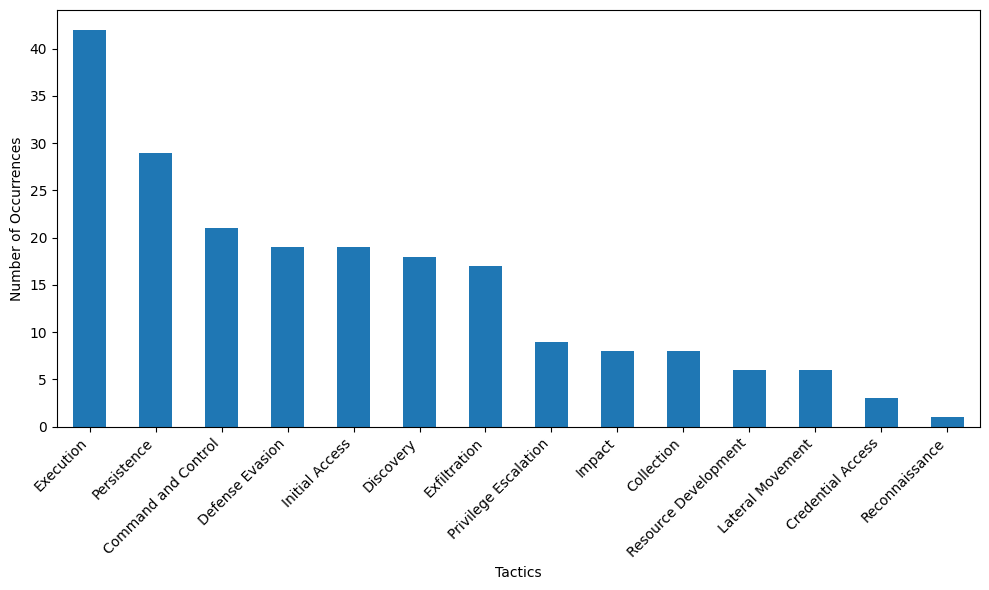

In [115]:
exploded_blackberry_df = blackberry_df.explode('tactics')

tactic_counts = exploded_blackberry_df['tactics'].value_counts()

plt.figure(figsize=(10, 6))
tactic_counts.plot(kind='bar')
plt.xlabel('Tactics')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Tagged dataset

In [ ]:
tagged_df = fetch_and_preprocess_data(DATABASE_NAME, "dataset", CONNECTION_STRING,
                                          preprocess=True, include_tactics=True, field_to_get="tactics")


[+] Shape: (156, 2)


[nltk_data] Downloading package punkt to /home/dani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tagged_df

,corpus,tactics
0,decoding network data gh0st rat variant nccgro...,"[Execution, Persistence, Credential Access, Co..."
1,5www .prevailion.com /what-wicked-webs-we-unwe...,"[Credential Access, Defense Evasion, Exploitat..."
2,7www .mandiant.com /resources/blog/lightshift-...,"[Defense Evasion, Privilege Escalation, Execut..."
3,2015/11/24 russian financial cybercrime works ...,"[Credential Access, Exfiltration, Persistence]"
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,"[Persistence, Credential Access, Command and C..."
...,...,...
151,first release time 14:32 may 27 2015 updated t...,"[Execution, Command and Control, Defense Evasi..."
152,10/1/2019 helo innti attack scan lastline http...,"[Initial Access, Execution, Persistence, Defen..."
153,9/9/2020 teamtnt activity tar gets eave scope ...,"[Initial Access, Execution, Persistence, Privi..."
154,2stisc-gov-md.translate.goog /ro/stisc-atentie...,"[Initial Access, Credential Access, Collection]"


In [ ]:
tagged_df['preprocessed_corpus'] = tagged_df['corpus'].apply(preprocess_text)
tagged_df

,corpus,tactics,preprocessed_corpus
0,decoding network data gh0st rat variant nccgro...,"[Execution, Persistence, Credential Access, Co...",decoding network data gh0st rat variant nccgro...
1,5www .prevailion.com /what-wicked-webs-we-unwe...,"[Credential Access, Defense Evasion, Exploitat...",5www prevailion com wicked web unweave icked e...
2,7www .mandiant.com /resources/blog/lightshift-...,"[Defense Evasion, Privilege Escalation, Execut...",7www mandiant com resource blog lightshift lig...
3,2015/11/24 russian financial cybercrime works ...,"[Credential Access, Exfiltration, Persistence]",2015 11 24 russian financial cybercrime work s...
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,"[Persistence, Credential Access, Command and C...",9 28 21 4 23 pm foggyw eb argeted nobelium mal...
...,...,...,...
151,first release time 14:32 may 27 2015 updated t...,"[Execution, Command and Control, Defense Evasi...",first release time 14 32 may 27 2015 updated t...
152,10/1/2019 helo innti attack scan lastline http...,"[Initial Access, Execution, Persistence, Defen...",10 1 2019 helo innti attack scan lastline http...
153,9/9/2020 teamtnt activity tar gets eave scope ...,"[Initial Access, Execution, Persistence, Privi...",9 9 2020 teamtnt activity tar get eave scope d...
154,2stisc-gov-md.translate.goog /ro/stisc-atentie...,"[Initial Access, Credential Access, Collection]",2stisc gov md translate goog ro stisc atentie ...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tagged_df['preprocessed_corpus'])

# Binarize the tactics column
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(tagged_df['tactics'])

# Create DataFrames for easier manipulation
words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tactics_df = pd.DataFrame(Y, columns=mlb.classes_)

# Concatenate the words and tactics DataFrames
combined_df = pd.concat([words_df, tactics_df], axis=1)

# Calculate correlation matrix
correlation_matrix = combined_df.corr()

# Extract correlations between words and tactics
word_tactic_correlations = correlation_matrix.loc[vectorizer.get_feature_names_out(), mlb.classes_]

# Display correlations
print(word_tactic_correlations)

              Collection  Command and Control  Credential Access  \
00             -0.036275            -0.093573           0.007131   
000             0.156810            -0.148449           0.122766   
0000            0.039443             0.036493          -0.126758   
00000000        0.038303            -0.150001           0.149351   
000000000000    0.120483             0.047960          -0.060947   
...                  ...                  ...                ...   
zxhn           -0.053548             0.047960           0.105856   
zy              0.120483             0.047960           0.105856   
zyber          -0.053548             0.047960          -0.060947   
zyns            0.120483             0.047960           0.105856   
zz             -0.053548             0.047960          -0.060947   

              Defense Evasion  Delivery  Discovery  Execution  Exfiltration  \
00                   0.054873 -0.021630   0.016180   0.065478     -0.118047   
000                  0.03

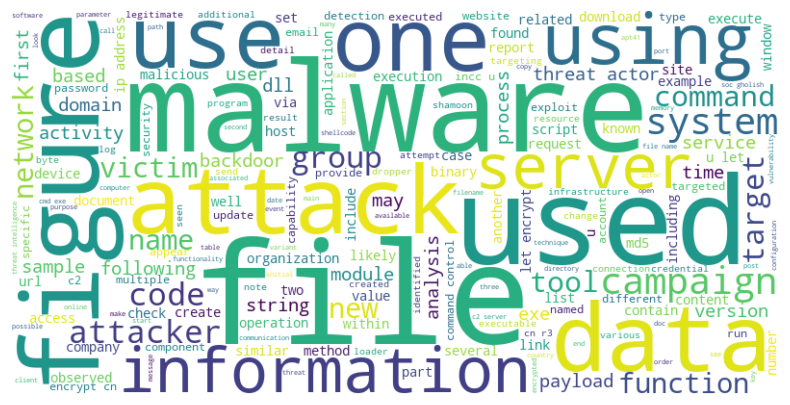

In [ ]:
from wordcloud import WordCloud

text = ' '.join(tagged_df['preprocessed_corpus'].values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # hiding the axes
plt.show()

In [ ]:
top_correlations = word_tactic_correlations.unstack().sort_values(ascending=False).head(50)


print("Top Correlations between words and tactics:")
print(top_correlations)

Top Correlations between words and tactics:
Delivery              survival                                                            1.0
Resource Development  burma                                                               1.0
                      cial                                                                1.0
Delivery              mirosoft                                                            1.0
Resource Development  framed                                                              1.0
                      pyongyang                                                           1.0
                      residence                                                           1.0
                      reprinting                                                          1.0
                      remit                                                               1.0
Delivery              6a207ea9d9e60a9bc9de7b1c2b87e06fa85ac31cbbf8c69e1627408c8f3d2b7f    1.0
Resource Develop

In [ ]:
def get_top_correlations_per_label(correlation_matrix, top_n=10):
    top_correlations_dict = {}
    for label in correlation_matrix.columns:
        top_correlations = correlation_matrix[label].sort_values(ascending=False).head(top_n)
        top_correlations_dict[label] = top_correlations
    return top_correlations_dict

# Get top correlations for each label
top_correlations_per_label = get_top_correlations_per_label(word_tactic_correlations)

# Print the top correlations for each label
for label, correlations in top_correlations_per_label.items():
    print(f"Top correlations for '{label}':")
    print(correlations)
    print("\n")

# Alternatively, you can convert the top correlations into a more structured format, like a DataFrame, for better readability.
top_correlations_df = pd.DataFrame(top_correlations_per_label)
print(top_correlations_df)

Top correlations for 'Collection':
collect        0.346493
malicious      0.282304
movement       0.280478
delete         0.276082
steal          0.274001
drive          0.263790
collecting     0.263393
screenshots    0.263339
storage        0.257971
mail           0.257123
Name: Collection, dtype: float64


Top correlations for 'Command and Control':
threat        0.200204
monitoring    0.199686
mimic         0.185727
fer           0.174304
collection    0.173630
iocs          0.170639
redirected    0.163563
typically     0.161925
directed      0.156267
far           0.154894
Name: Command and Control, dtype: float64


Top correlations for 'Credential Access':
credential    0.453763
gain          0.396688
dumping       0.334031
running       0.331734
year          0.321454
database      0.317920
password      0.316477
recorded      0.299552
deployed      0.295892
microsoft     0.293953
Name: Credential Access, dtype: float64


Top correlations for 'Defense Evasion':
process        0.2

Negative correlations

In [ ]:
top_negative_correlations = word_tactic_correlations.unstack().sort_values().head(10)

In [ ]:
def get_top_negative_correlations_per_label(correlation_matrix, top_n=10):
    top_negative_correlations_dict = {}
    for label in correlation_matrix.columns:
        top_negative_correlations = correlation_matrix[label].sort_values().head(top_n)
        top_negative_correlations_dict[label] = top_negative_correlations
    return top_negative_correlations_dict

# Get top negative correlations for each label
top_negative_correlations_per_label = get_top_negative_correlations_per_label(word_tactic_correlations)

# Print the top negative correlations for each label
for label, correlations in top_negative_correlations_per_label.items():
    print(f"Top negative correlations for '{label}':")
    print(correlations)
    print("\n")

# Alternatively, you can convert the top negative correlations into a more structured format, like a DataFrame, for better readability.
top_negative_correlations_df = pd.DataFrame(top_negative_correlations_per_label)
print(top_negative_correlations_df)


Top negative correlations for 'Collection':
win          -0.186991
highest      -0.183620
examine      -0.182621
passed       -0.175713
fix          -0.173926
employ       -0.171911
utilizing    -0.171121
80           -0.169547
originally   -0.168146
false        -0.167443
Name: Collection, dtype: float64


Top negative correlations for 'Command and Control':
lower        -0.294062
processing   -0.292045
producing    -0.289915
victimized   -0.288640
tried        -0.286927
2017         -0.286663
ch           -0.282904
anonymous    -0.279686
ion          -0.271685
maximize     -0.271685
Name: Command and Control, dtype: float64


Top negative correlations for 'Credential Access':
tag         -0.182925
fer         -0.178203
ara         -0.166215
opinion     -0.164466
gas         -0.160712
vt          -0.158794
submitted   -0.156835
fix         -0.156283
normally    -0.156283
deep        -0.155857
Name: Credential Access, dtype: float64


Top negative correlations for 'Defense Evasion':
ya

/tmp/ipykernel_4538/4184747744.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tactic_counts.index, y=tactic_counts.values, palette="viridis")


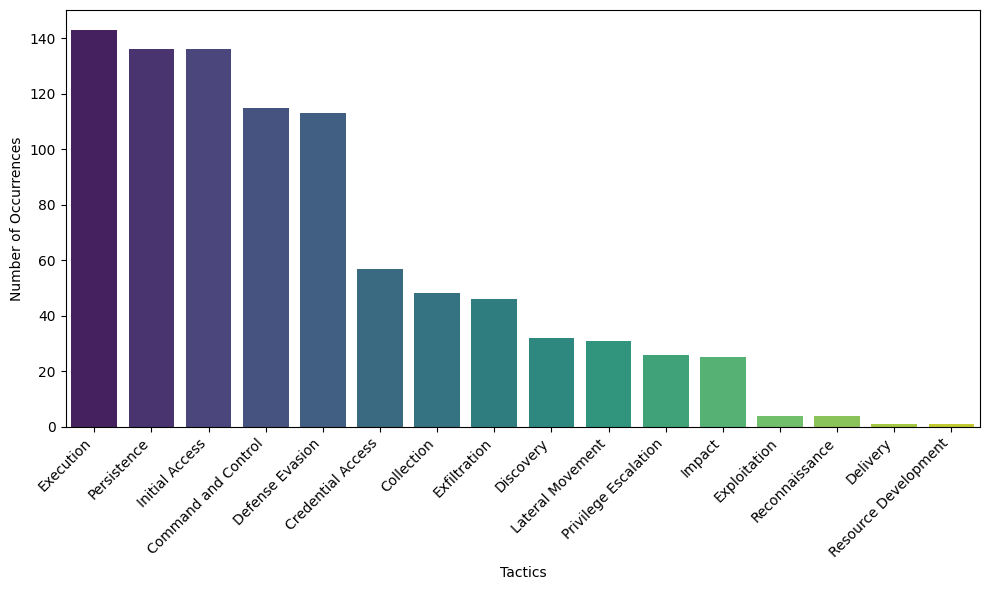

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

exploded_tagged_df = tagged_df.explode('tactics')

tactic_counts = exploded_tagged_df['tactics'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tactic_counts.index, y=tactic_counts.values, palette="viridis")
plt.xlabel('Tactics')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Co-occurrence study

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

#TODO: add to utils

In [116]:
def plot_co_occurrence_matrix(df, column_name='tactics'):
    """
    Plot and display the co-occurrence matrix for the given dataframe and column.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    column_name (str): The name of the column containing the list of labels (default is 'tactics').

    Returns:
    None
    """
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(df[column_name])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

    # co-occurrence matrix
    co_occurrence_matrix = one_hot_df.T.dot(one_hot_df)

    # mask for the upper triangle
    mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

    # plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="viridis", mask=mask, cbar=False)
    plt.xlabel('Tactics')
    plt.ylabel('Tactics')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

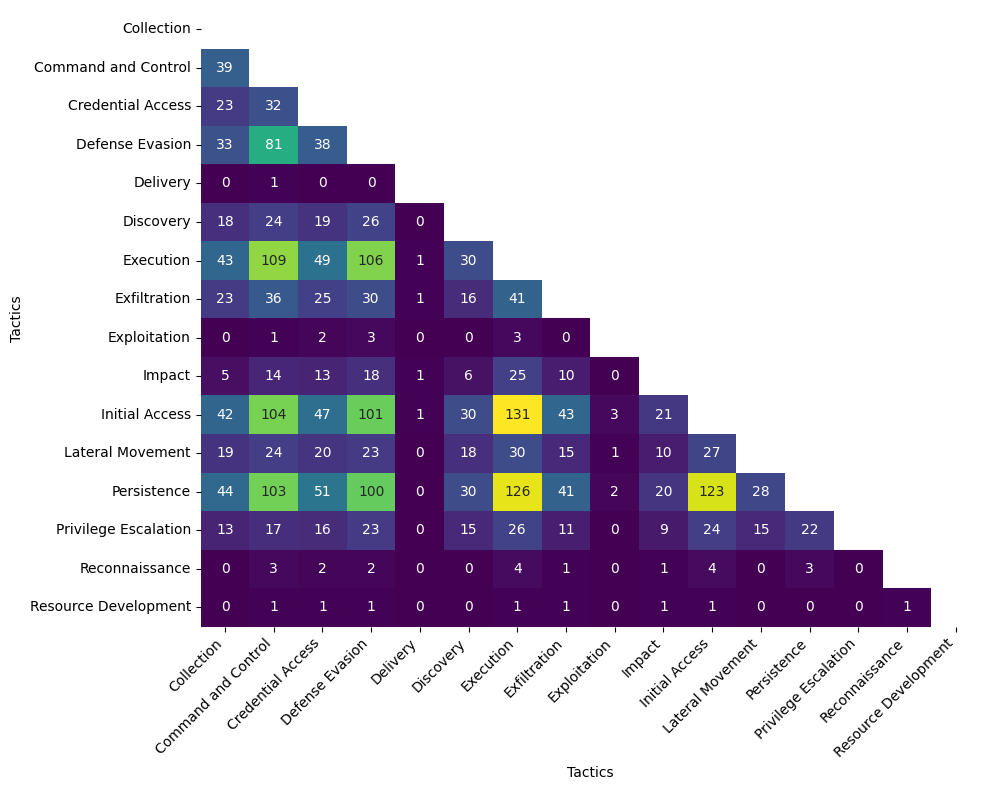

In [ ]:
plot_co_occurrence_matrix(tagged_df)

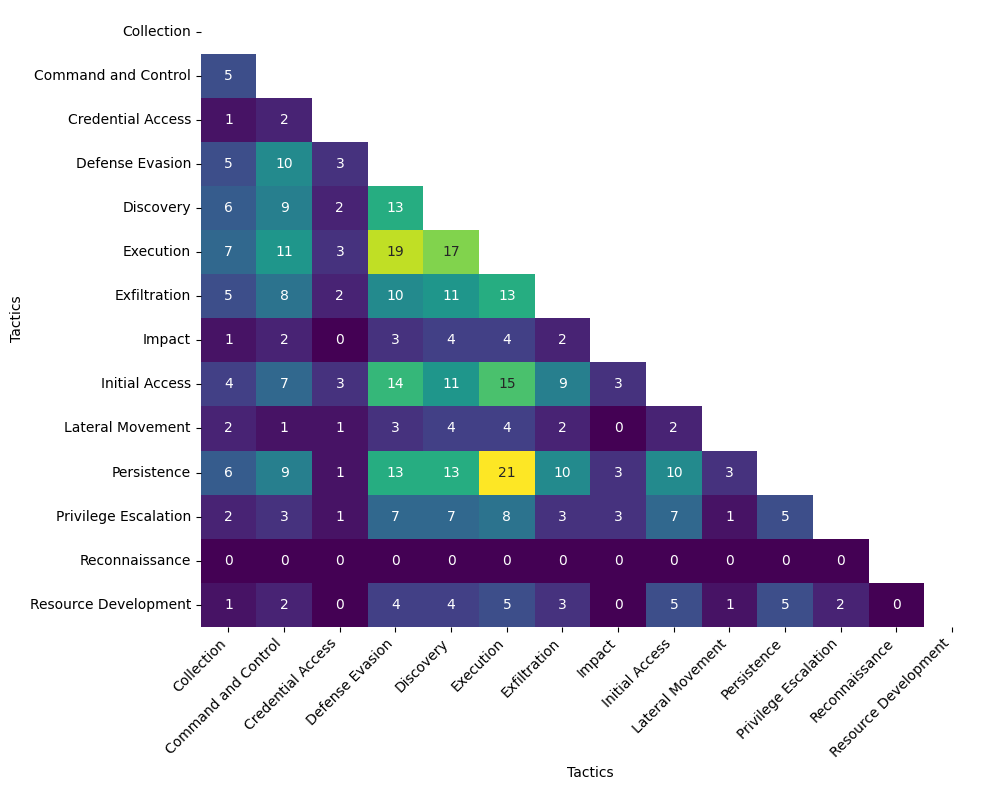

In [117]:
plot_co_occurrence_matrix(blackberry_df)